# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *J*

**Names:**

* *Rafael Bischof*
* *Jeniffer Lima Graf*
* *Alexander Sanchez*

---

#### Instructions

*This is a template for part 3 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.3 Epdemics

#### Exercise 2.9: Simulate an epidemic outbreak

In [1]:
import epidemics_helper
import os
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
with open(os.path.join('../data/nyc_augmented_network.json')) as file:
    data = json.load(file)
G = nx.readwrite.json_graph.node_link_graph(data)
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Number of nodes: 26481
Number of edges: 43437


In [3]:
sir = epidemics_helper.SimulationSIR(G, beta=10.0, gamma=0.1, verbose=False)

In [4]:
sir.launch_epidemic(source=23654, max_time=100.0)

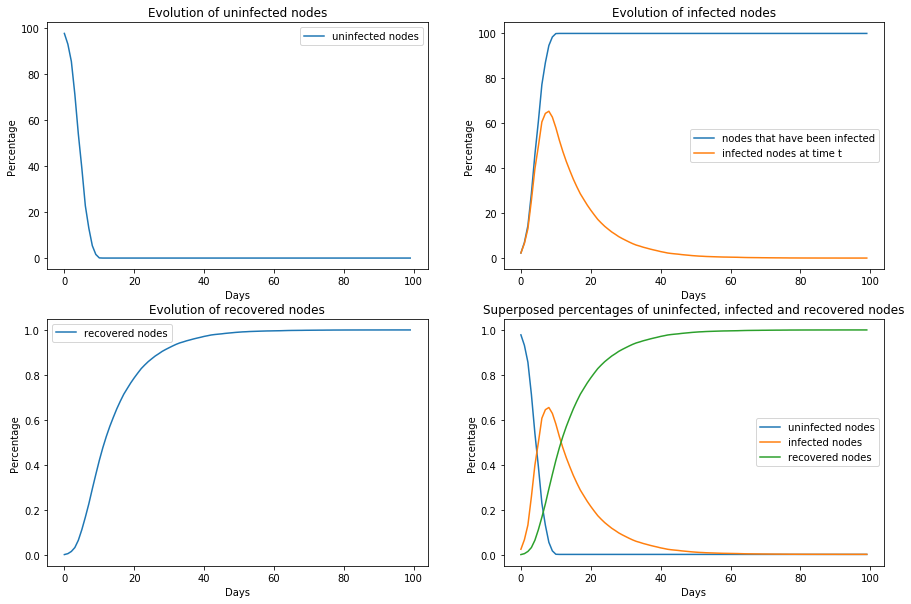

In [5]:
def status(sir):
    r = sir.rec_time.astype(int)
    r_c = np.cumsum(np.bincount(r[r > 0], minlength=100))
    i = sir.inf_time.astype(int)
    i_c = np.cumsum(np.bincount(i[i >= 0], minlength=100))
    h_c = np.zeros(100) + sir.n_nodes - i_c
    return h_c, i_c, r_c

h_c, i_c, r_c = status(sir)
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title('Evolution of susceptible nodes')
plt.plot(h_c / sir.n_nodes * 100, label='susceptible nodes')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.legend()
plt.subplot(2,2,2)
plt.title('Evolution of infected nodes')
plt.plot(i_c / sir.n_nodes * 100, label='nodes that have been infected')
plt.plot((i_c - r_c) / sir.n_nodes * 100, label='infected nodes at time t')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.legend()
plt.subplot(2,2,3)
plt.title('Evolution of recovered nodes')
plt.plot(r_c / sir.n_nodes, label='recovered nodes')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.legend()
plt.subplot(2,2,4)
plt.title('Superposed percentages of uninfected, infected and recovered nodes')
plt.plot(h_c / sir.n_nodes, label='uninfected nodes')
plt.plot((i_c - r_c) / sir.n_nodes, label='infected nodes')
plt.plot(r_c / sir.n_nodes, label='recovered nodes')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.legend()

In [6]:
print('Time until 60% of population infected:', len(i_c[i_c < sir.n_nodes*.6]), 'days')
print('Time until 60% of population dead:', len(r_c[r_c < sir.n_nodes*.6]), 'days')

Time until 60% of population infected: 5 days
Time until 60% of population dead: 14 days


In [7]:
def visualize_epidemics(sir, src, days, order):
    sir.launch_epidemic(source=src, max_time=days)
    colors = ['green', 'red', 'black']
    classes = ['healthy', 'infected', 'dead']
    xcoord = [[],[],[]]
    ycoord = [[],[],[]]
    for i in range(G.number_of_nodes()):
        x, y = (G.node[i])['coordinates']
        xcoord[sir.status[i]] = np.append(xcoord[sir.status[i]], x / 1e6)
        ycoord[sir.status[i]] = np.append(ycoord[sir.status[i]], y / 1e6)
    plt.scatter(xcoord[order[0]], ycoord[order[0]], c=colors[order[0]], label=classes[order[0]], s=2)
    plt.scatter(xcoord[order[1]], ycoord[order[1]], c=colors[order[1]], label=classes[order[1]], s=2)
    plt.scatter(xcoord[order[2]], ycoord[order[2]], c=colors[order[2]], label=classes[order[2]], s=2)

    plt.title('Epidemic after %d days' % days)
    plt.xlabel('latitude')
    plt.ylabel('longitude')
    plt.legend()

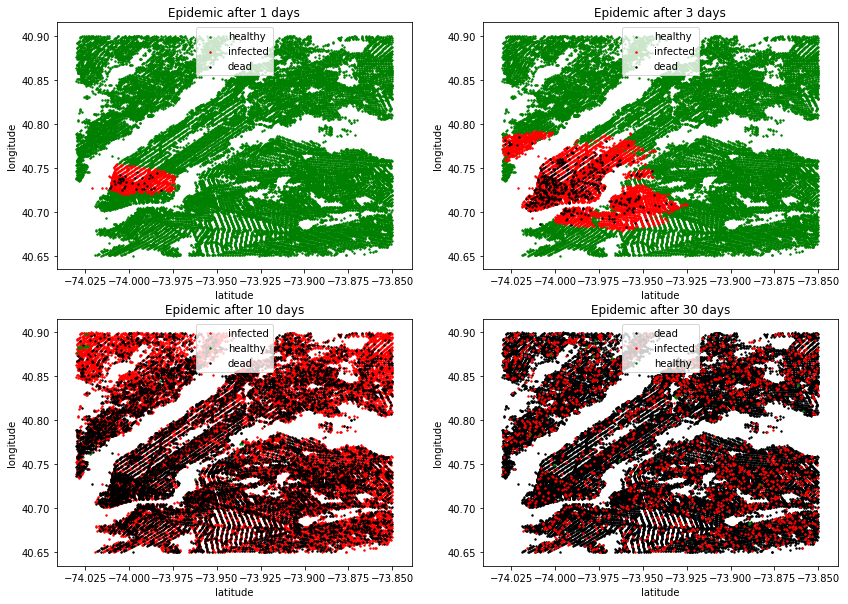

In [8]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
visualize_epidemics(sir, 23654, 1, [0,1,2])
plt.subplot(2,2,2)
visualize_epidemics(sir, 23654, 3, [0,1,2])
plt.subplot(2,2,3)
visualize_epidemics(sir, 23654, 10, [1,0,2])
plt.subplot(2,2,4)
visualize_epidemics(sir, 23654, 30, [2,1,0])

---

### 2.3.1 Stop the apocalypse!

#### Exercise 2.10: Strategy 1

In [ ]:
H_1000 = G.copy()
H_10000 = G.copy()

edges = list(G.edges)
np.random.shuffle(edges)
rem_edges_1000 = edges[:1000]
np.random.shuffle(edges)
rem_edges_10000 = edges[:10000]

for edge in rem_edges_1000:
    H_1000.remove_edge(*edge)
for edge in rem_edges_10000:
    H_10000.remove_edge(*edge)
    
sir_1000 = epidemics_helper.SimulationSIR(H_1000, beta=10.0, gamma=0.1, verbose=False)
sir_10000 = epidemics_helper.SimulationSIR(H_10000, beta=10.0, gamma=0.1, verbose=False)

In [10]:
def mean_percentages_after_30_days(G, sir):
    stats = np.zeros((10,3))
    for i in range(100):
        np.random.seed(i)
        src = np.random.choice(range(G.number_of_nodes()))
        sir.launch_epidemic(source=src, max_time=30)
        perc = status(sir)
        for j in range(3):
            stats[i][j] = perc[j][-1]
        
    return np.round(np.mean(stats, axis=0) / sir.n_nodes * 100)

In [11]:
normal = mean_percentages_after_30_days(G, sir)
leveraged_1000 = mean_percentages_after_30_days(G, sir_1000)
leveraged_10000 = mean_percentages_after_30_days(G, sir_10000)

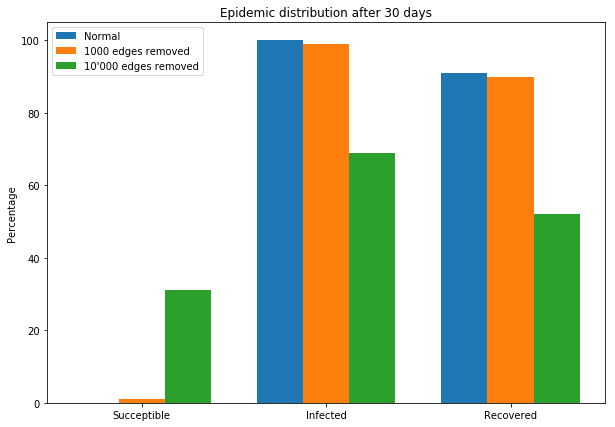

In [12]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ind = np.arange(3)
width = .25
n = ax.bar(ind, normal, width)
lev_1000 = ax.bar(ind+width, leveraged_1000, width)
lev_10000 = ax.bar(ind+2*width, leveraged_10000, width)

ax.set_ylabel('Percentage')
ax.set_title('Epidemic distribution after 30 days')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('Succeptible', 'Infected', 'Recovered') )

ax.legend((n, lev_1000, lev_10000),('Normal', '1000 edges removed', "10'000 edges removed"))

plt.show()

#### Exercise 2.11: Strategy 2

Our goal is to seperate as many components as possible. So we look for the bridge nodes which connect two nodes (the nodes which have a degree 2 or higher). And we try to remove as many as the budget allows us.

In [55]:
rem_bridges = G.copy()
deg_sorted = list(sorted(G.degree, key = lambda x: x[1]))
#keep all the nodes with degree more than one
bridges = [n for n in deg_sorted if n[1] >= 2]

list(G.edges)[:4]
e = list(G.edges)[0]
rem_bridges.remove_edge(*e)
list(rem_bridges.edges)[:4]

[(0, 29), (1, 26279), (1, 39), (2, 26300)]

In [3]:
def removeBridgeEdges(G, budget):
    rem_bridges = G.copy()
    edges = list(G.edges)
    
    b = min(budget, len(edges))
    
    def isBridge(node):
        return rem_bridges.degree(node) >= 2

    def hasSingleEdge(node):
        return rem_bridges.degree(node) == 1
    
    while (b > 0 and len(rem_bridges.edges) > 0):
        #sort the nodes according to their degree
        deg_sorted = list(sorted(rem_bridges.degree, key = lambda x: x[1]))
        #keep all with deg >= 2
        deg_sorted = [n for n in deg_sorted if n[1] >= 2]
        if (len(deg_sorted) == 0):
            for i in range(b):
                rem_bridges.remove_edge(0)
            b = 0
        else:
            while(len(deg_sorted) > 0 and budget > 0):
                node = deg_sorted[0][0]
                if isBridge(node):
                    candidate_edges = filter(lambda e: e[0] == node or e[1] == node, list(rem_bridges.edges))
                    rem_bridges.remove_edge(*next(candidate_edges))
                    b = b -1
                if hasSingleEdge(node):
                    deg_sorted = deg_sorted[1:]

In [ ]:
sir_1000_2 = epidemics_helper.SimulationSIR(removeBridgeEdges(G, 1000), beta=10.0, gamma=0.1, verbose=False)
sir_10000_2 = epidemics_helper.SimulationSIR(removeBridgeEdges(G, 10000), gamma=0.1, verbose=False)

In [ ]:
leveraged_1000_2 = mean_percentages_after_30_days(G, sir_1000_2)
leveraged_10000_2 = mean_percentages_after_30_days(G, sir_10000_2)

In [ ]:
#conn_components = sorted(nx.connected_components(G), key = len, reverse=True)
#giant = conn_components[0]
#giant_graph = G.subgraph(giant).copy()
#cuts = list(nx.all_node_cuts(giant_graph))